# Optimization Setup + Visualization

In [1]:
# External libraries
import pandas as pd
import numpy as np
import pygad
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import umap
from matplotlib import cm

# Our classes
from optimization_pipeline.SIM import *
from optimization_pipeline.preprocessing import *

### Preprocess for True Strain

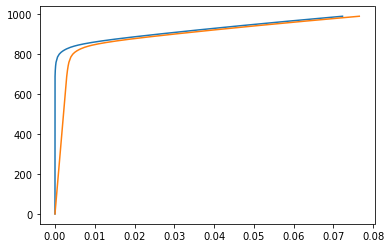

In [2]:
cp3 = pd.read_csv('CP_2.csv')
strain = cp3.iloc[:,1]
stress = cp3.iloc[:,0]
TPstrain = getTruePlasticStrain(strain, stress)
pd.DataFrame(dict(zip(('Stress MPa', 'True Plastic Strain'),(stress, TPstrain)))).to_csv('CP2_Demo.csv', index=False)
plt.plot(TPstrain, stress)
plt.plot(strain, stress)

### Plot Simulation

In [15]:
sims = np.load('simulations.npy', allow_pickle=True).item()
len(sims)

34

34


Text(0.5, 0, 'Strain')

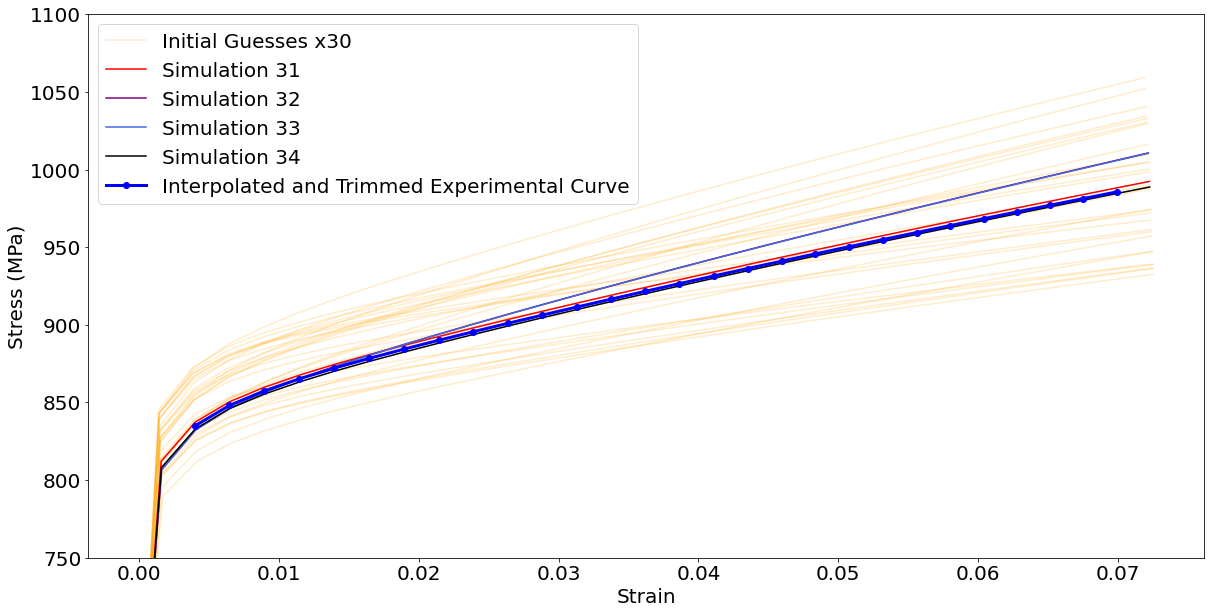

In [16]:
cp2 = pd.read_csv('CP2_Demo.csv')
exp_stress = cp2.iloc[:,0] # Take first column
exp_strain = cp2.iloc[:,1] # Take second column
f = interp1d(exp_strain, exp_stress)
x_min, x_max = 0.002, exp_strain.max()
sim_strain = np.array([strain for (strain,_) in sims.values()]).mean(axis=0)
prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
sim_strain = sim_strain[prune]
exp_target = f(sim_strain).reshape(1,len(sim_strain))
y = np.array([stress[prune] for (_, stress) in sims.values()])


plt.figure(figsize=(20,10))
plt.ylim([750,1100])
#sims = np.load('simulations_CP2.npy', allow_pickle=True).item()
print(len(sims))
for (strain, stress) in sims.values():
    plt.plot(strain, stress, c='orange', alpha=0.2, label="Initial Guesses x30")
colors = ['red', 'purple', 'royalblue', 'black', 'green']
i = 0
for key in list(sims.keys())[-4:]:
    plt.plot(*sims[key], c=colors[i], label=f"Simulation {30+i+1}")
    i += 1

#plt.plot(exp.iloc[:,1],exp.iloc[:,0], 'g-o', c='blue', label="Experimental Flow Curve")
plt.plot(sim_strain, exp_target.flatten(), 'g-o', linewidth=3, c='blue', label="Interpolated and Trimmed Experimental Curve")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 20})
plt.ylabel("Stress (MPa)", fontsize=20)
plt.xlabel("Strain", fontsize=20)

### Plot Fitness for 5 Curves

In [18]:
# D1 loss function: L2 loss 
plt.rc('font', size=20)          # controls default text sizes

def D1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def D2(exp_stress, sim_stress, strainobj): # Added strainobj as an input
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def D3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def D4(exp_stress, sim_stress, strainobj):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return np.max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness(exp_stress, sim_stress,strainobj, w1, w2, w3, w4):
    return ( w1*D1(exp_stress, sim_stress) + w2*D2(exp_stress, sim_stress, strainobj) 
            + w3*D3(exp_stress, sim_stress) + w4*D4(exp_stress, sim_stress, strainobj))

# Testing on every index of sigma_hats
resD1 = []
resD2 = []
resD3 = []
resD4 = []
res_fit = []
w1 = 0.9
w2 = 0.005
w4 = 0.009
w3 = 1 - w1 - w2 - w4


labels = ['31st Simulation', '32nd Simulation', '33rd Simulation', '34th Simulation']

for sim_stress in y:
    resD1.append(D1(exp_target, sim_stress))
    resD2.append(D2(exp_target, sim_stress, sim_strain))
    resD3.append(D3(exp_target, sim_stress))
    resD4.append(D4(exp_target, sim_stress, sim_strain))
    res_fit.append(fitness(exp_target, sim_stress, sim_strain, w1, w2, w3, w4))

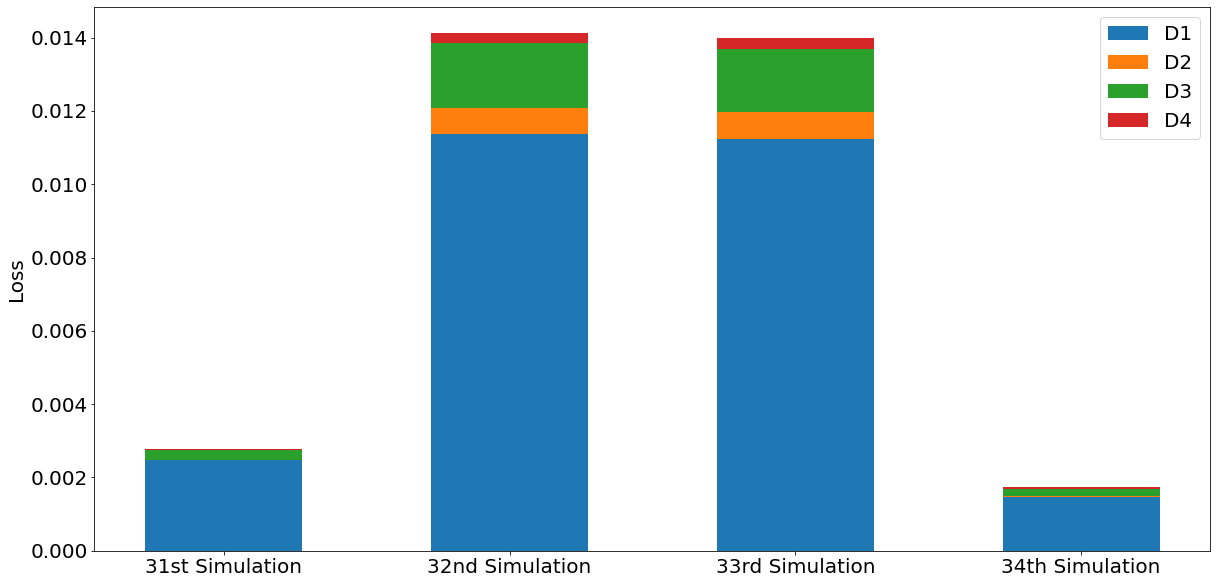

In [20]:
width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))
L1 = np.array(resD1)[-4:]*w1
L2 = np.array(resD2)[-4:]*w2
L3 = np.array(resD3)[-4:]*w3
L4 = np.array(resD4)[-4:]*w4

ax.bar(labels, L1, width, label='D1')
ax.bar(labels, L2, width, bottom=L1 , label='D2')
ax.bar(labels, L3, width, bottom=L1+L2, label='D3')
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4')

#plt.hlines(res_fit[2], xmin=-0.55, xmax=4.55, linestyles='dashed')
ax.set_ylabel('Loss',size=20)
ax.legend(prop={'size': 20})
plt.show()